## Library Comparisons
There are a number of TDA libraries. In this notebook, we test how quickly each of them run and how accurate they all are compared to each other. We focus on comparing `OATpy`, `Ripser`, and `GUDHI`, although more could be added (ex. `Giotto TDA` or `scikit-tda`).

In general, we find that `Ripser` is the fastest, `OATpy` is a few times slower, and `GUDHI` is the slowest by orders of magnitude for point clouds and that `GUDHI` is that fastest, `Ripser` is a few times slower, and `OATpy` is much, much slower for networks. The barcodes from the libraries are all similar, with `OATpy` and `GUDHI` finding homological features with the same birth and death times and `Ripser` finding features with birth and death times that are very close to the other libraries.

This means `Ripser` and `GUDHI` are the preferred libraries for speed depending on the initial input, but `OATpy` is similar enough, especially considering the additional features the library has, that it's also a really good option.

#### Preliminaries
A couple important packages and the TDA libraries for comparison

In [1]:
# general libraries
import sys; sys.path.append('/Users/gavinengelstad/hera/build/bindings/python') # hera
import Gavin.utils.random_complexes as rc
import Gavin.utils.compare_barcodes as cb
import Gavin.utils.make_network_v1 as mn
import matplotlib.pyplot as plt
import networkx as nx
from time import time
import pandas as pd
import numpy as np

# tda libraries
from gudhi import RipsComplex
from ripser import ripser
import oatpy as oat

#### Test Functions
Any tests will be done in the following functions. Each function will have a clearly specified number of dimensions to search for homology for and max filtration value to keep everything even.

Some tests will use point clouds and others will use networks to get a good view of all applications of the libraries.

In [2]:
## ripser functions
def ripser_from_cloud(cloud, max_dim, max_filtration):
    start = time()

    res = ripser(X=cloud, maxdim=max_dim, thresh=max_filtration)

    time_to_solve = time() - start

    return cb.format_ripser_output(res), time_to_solve


def ripser_from_adj_martix(adj, max_dim):
    start = time()

    res = ripser(X=adj, maxdim=max_dim, distance_matrix=True)

    time_to_solve = time() - start

    return cb.format_ripser_output(res), time_to_solve


In [3]:
## oat functions
def oat_from_cloud(cloud, max_dim, max_filtration):
    start = time()

    dissimilairty_matrix = oat.dissimilarity.matrix_from_cloud( # distance matrix
            cloud=cloud,
            dissimilarity_max=max_filtration # i belive any elements past this are removed (returns a sparse matrix)
        )
    # add 1e-10 to elimite some numerical error (greg says to do it)
    factored = oat.rust.FactoredBoundaryMatrixVr( # two functions that do this, idk what the other one is
            dissimilarity_matrix=dissimilairty_matrix,
            homology_dimension_max=max_dim
        )
    res = factored.homology( # solve homology
            return_cycle_representatives=False, # These need to be true to be able to make a barcode, but false to be a bit faster
            return_bounding_chains=False
        )

    time_to_solve = time() - start

    return cb.format_oat_output(res), time_to_solve


def oat_from_adj_martix(adj, max_dim):
    start = time()

    factored = oat.rust.FactoredBoundaryMatrixVr( # two functions that do this, idk what the other one is
            dissimilarity_matrix=adj,
            homology_dimension_max=max_dim
        )
    res = factored.homology( # solve homology
            return_cycle_representatives=False, # These need to be true to be able to make a barcode, but false to be a bit faster
            return_bounding_chains=False
        )
    
    time_to_solve = time() - start

    return cb.format_oat_output(res), time_to_solve

In [4]:
## gudhi functions
def gudhi_from_cloud(cloud, max_dim, max_filtration):
    start = time()

    # calculate homology
    rips = RipsComplex(points=cloud, max_edge_length=max_filtration)
    simplex_tree = rips.create_simplex_tree(max_dimension=max_dim+1) # +1 otherwise we only get max_dim-1 dimentional features
    res = simplex_tree.persistence()

    time_to_solve = time() - start

    return cb.format_guhdi_output(res), time_to_solve


def gudhi_from_adj_martix(adj, max_dim):
    adj = adj.toarray() # gudhi doesn't like sparse matricies
    adj[adj == 0] = np.inf

    start = time()

    # calculate homology
    rips = RipsComplex(distance_matrix=adj, max_edge_length=1)
    simplex_tree = rips.create_simplex_tree(max_dimension=max_dim+1) # +1 otherwise we only get max_dim-1 dimentional features
    res = simplex_tree.persistence()

    time_to_solve = time() - start

    return cb.format_guhdi_output(res), time_to_solve


### Test 1: 2D Point Cloud
Test all the libraries on a 2D point cloud

#### Set Up the Test

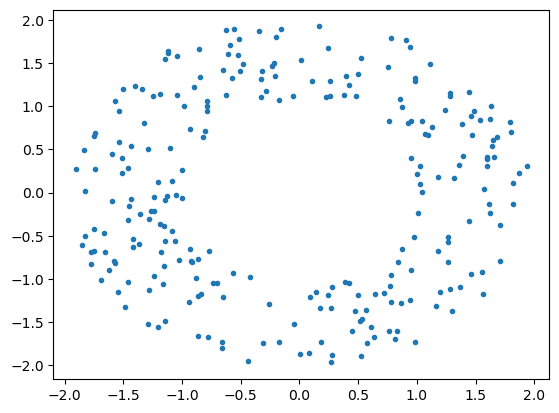

In [5]:
# test parameters
MAX_DIMENSION = 2
NUMBER_OF_POINTS = 250

# get points
pts = oat.point_cloud.annulus(npoints=NUMBER_OF_POINTS, random_seed=10)
enclosing = oat.dissimilarity.enclosing_from_cloud(pts) + 1e-10  # max filtration radius
enclosing

# plot it
ax = plt.subplot()
ax.plot(pts[:, 0], pts[:, 1], '.')

#### Use the Three Libraries
Calculate homology using all three libraries. Keep track of
1. The barcodes we find
2. How long they all take

In [6]:
ripser_res, ripser_t = ripser_from_cloud(pts, MAX_DIMENSION, enclosing)
oat_res, oat_t = oat_from_cloud(pts, MAX_DIMENSION, enclosing)
gudhi_res, gudhi_t = gudhi_from_cloud(pts, MAX_DIMENSION, enclosing)

#### Comparisons
The first code block compares the time each library took. The other ones use different distance metrics and different dimensions to compare the outputted barcodes.

In [7]:
## Time it takes
pd.DataFrame(data={'Library': ['Ripser', 'OAT', 'GUDHI'], 'Time (sec)': [ripser_t, oat_t, gudhi_t]})

,Library,Time (sec)
0,Ripser,0.982275
1,OAT,3.615429
2,GUDHI,49.269042


In [8]:
## Wasserstein Distance between dimension 0 features
cb.barcode_distance_matrix(
        [ripser_res, oat_res, gudhi_res],
        cb.wasserstein_distance,
        dim=0,
        labels=['Ripser', 'OAT', 'GUDHI'],
    )

,Ripser,OAT,GUDHI
Ripser,0.000000,0.000004,0.000004
OAT,0.000004,0.000000,0.000000
GUDHI,0.000004,0.000000,0.000000


In [9]:
## Wasserstein Distance between dimension 1 features
cb.barcode_distance_matrix(
        [ripser_res, oat_res, gudhi_res],
        cb.wasserstein_distance,
        dim=1,
        labels=['Ripser', 'OAT', 'GUDHI'],
    )

,Ripser,OAT,GUDHI
Ripser,0.000000e+00,3.494091e-07,3.494091e-07
OAT,3.494091e-07,0.000000e+00,0.000000e+00
GUDHI,3.494091e-07,0.000000e+00,0.000000e+00


In [10]:
## Wasserstein Distance between dimension 2 features
cb.barcode_distance_matrix(
        [ripser_res, oat_res, gudhi_res],
        cb.wasserstein_distance,
        dim=2,
        labels=['Ripser', 'OAT', 'GUDHI'],
    )

,Ripser,OAT,GUDHI
Ripser,0.000000e+00,6.029070e-08,6.029070e-08
OAT,6.029070e-08,0.000000e+00,0.000000e+00
GUDHI,6.029070e-08,0.000000e+00,0.000000e+00


In [11]:
## Persistance Images Distance between dimension 0 features
cb.barcode_distance_matrix(
        [ripser_res, oat_res, gudhi_res],
        cb.persistance_image_distance,
        dim=0,
        labels=['Ripser', 'OAT', 'GUDHI'],
    )

,Ripser,OAT,GUDHI
Ripser,0.000000,0.000013,0.000013
OAT,0.000013,0.000000,0.000000
GUDHI,0.000013,0.000000,0.000000


In [12]:
## Persistance Images Distance between dimension 1 features
cb.barcode_distance_matrix(
        [ripser_res, oat_res, gudhi_res],
        cb.persistance_image_distance,
        dim=1,
        labels=['Ripser', 'OAT', 'GUDHI'],
    )

,Ripser,OAT,GUDHI
Ripser,0.000000e+00,3.229759e-07,3.229759e-07
OAT,3.229759e-07,0.000000e+00,0.000000e+00
GUDHI,3.229759e-07,0.000000e+00,0.000000e+00


In [13]:
## Persistance Images Distance between dimension 2 features
cb.barcode_distance_matrix(
        [ripser_res, oat_res, gudhi_res],
        cb.persistance_image_distance,
        dim=2,
        labels=['Ripser', 'OAT', 'GUDHI'],
    )

,Ripser,OAT,GUDHI
Ripser,0.000000e+00,8.265055e-08,8.265055e-08
OAT,8.265055e-08,0.000000e+00,0.000000e+00
GUDHI,8.265055e-08,0.000000e+00,0.000000e+00


### Test 2: 3D Point Cloud

Test all the libraries on a 3D point cloud.

#### Set Up the Test

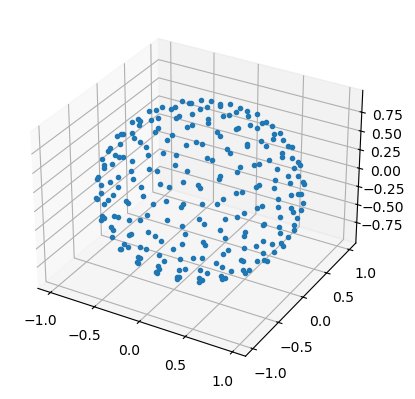

In [14]:
# test parameters
MAX_DIMENSION = 2
NUMBER_OF_POINTS = 250

# get points
pts = oat.point_cloud.slice_of_sphere(npoints=NUMBER_OF_POINTS, random_seed=10)
enclosing = oat.dissimilarity.enclosing_from_cloud(pts) + 1e-10  # max filtration radius
enclosing

# plot it
ax = plt.figure().add_subplot(projection='3d')
ax.plot(pts[:, 0], pts[:, 1], '.', zs=pts[:, 2])

#### Use the Three Libraries
Calculate homology using all three libraries. Keep track of
1. The barcodes we find
2. How long they all take

In [15]:
ripser_res, ripser_t = ripser_from_cloud(pts, MAX_DIMENSION, enclosing)
oat_res, oat_t = oat_from_cloud(pts, MAX_DIMENSION, enclosing)
gudhi_res, gudhi_t = gudhi_from_cloud(pts, MAX_DIMENSION, enclosing)

#### Comparisons
The first code block compares the time each library took. The other ones use different distance metrics and different dimensions to compare the outputted barcodes.

In [16]:
## Time it takes
pd.DataFrame(data={'Library': ['Ripser', 'OAT', 'GUDHI'], 'Time (sec)': [ripser_t, oat_t, gudhi_t]})

,Library,Time (sec)
0,Ripser,3.177810
1,OAT,37.587881
2,GUDHI,131.934257


In [17]:
## Wasserstein Distance between dimension 0 features
cb.barcode_distance_matrix(
        [ripser_res, oat_res, gudhi_res],
        cb.wasserstein_distance,
        dim=0,
        labels=['Ripser', 'OAT', 'GUDHI'],
    )

,Ripser,OAT,GUDHI
Ripser,0.000000,0.000004,0.000004
OAT,0.000004,0.000000,0.000000
GUDHI,0.000004,0.000000,0.000000


In [18]:
## Wasserstein Distance between dimension 1 features
cb.barcode_distance_matrix(
        [ripser_res, oat_res, gudhi_res],
        cb.wasserstein_distance,
        dim=1,
        labels=['Ripser', 'OAT', 'GUDHI'],
    )

,Ripser,OAT,GUDHI
Ripser,0.000000,0.000005,0.000005
OAT,0.000005,0.000000,0.000000
GUDHI,0.000005,0.000000,0.000000


In [19]:
## Wasserstein Distance between dimension 2 features
cb.barcode_distance_matrix(
        [ripser_res, oat_res, gudhi_res],
        cb.wasserstein_distance,
        dim=2,
        labels=['Ripser', 'OAT', 'GUDHI'],
    )

,Ripser,OAT,GUDHI
Ripser,0.000000e+00,1.150975e-08,1.150975e-08
OAT,1.150975e-08,0.000000e+00,0.000000e+00
GUDHI,1.150975e-08,0.000000e+00,0.000000e+00


In [20]:
## Persistance Images Distance between dimension 0 features
cb.barcode_distance_matrix(
        [ripser_res, oat_res, gudhi_res],
        cb.persistance_image_distance,
        dim=0,
        labels=['Ripser', 'OAT', 'GUDHI'],
    )

,Ripser,OAT,GUDHI
Ripser,0.000000,0.000009,0.000009
OAT,0.000009,0.000000,0.000000
GUDHI,0.000009,0.000000,0.000000


In [21]:
## Persistance Images Distance between dimension 1 features
cb.barcode_distance_matrix(
        [ripser_res, oat_res, gudhi_res],
        cb.persistance_image_distance,
        dim=1,
        labels=['Ripser', 'OAT', 'GUDHI'],
    )

,Ripser,OAT,GUDHI
Ripser,0.00000,0.00001,0.00001
OAT,0.00001,0.00000,0.00000
GUDHI,0.00001,0.00000,0.00000


In [22]:
## Persistance Images Distance between dimension 2 features
cb.barcode_distance_matrix(
        [ripser_res, oat_res, gudhi_res],
        cb.persistance_image_distance,
        dim=2,
        labels=['Ripser', 'OAT', 'GUDHI'],
    )

,Ripser,OAT,GUDHI
Ripser,0.000000e+00,2.992254e-07,2.992254e-07
OAT,2.992254e-07,0.000000e+00,0.000000e+00
GUDHI,2.992254e-07,0.000000e+00,0.000000e+00


### Test 3: Random Network

Test all the libraries on an adjacency matrix for a randomly created network.

#### Set Up the Test

In [23]:
# test parameters
MAX_DIMENSION = 2
NUMBER_OF_NODES = 200
NETWORK_DENSITY = 0.25

# get points
adj = rc.erdos_renyi_complex(
        NUMBER_OF_NODES,
        density=NETWORK_DENSITY,
        seed=10
    )

# check
adj

<200x200 sparse matrix of type '<class 'numpy.float64'>'
	with 10150 stored elements in Compressed Sparse Row format>

#### Use the Three Libraries
Calculate homology using all three libraries. Keep track of
1. The barcodes we find
2. How long they all take

In [24]:
ripser_res, ripser_t = ripser_from_adj_martix(adj, MAX_DIMENSION)
oat_res, oat_t = oat_from_adj_martix(adj, MAX_DIMENSION)
gudhi_res, gudhi_t = gudhi_from_adj_martix(adj, MAX_DIMENSION)

#### Comparisons
The first code block compares the time each library took. The other ones use different distance metrics and different dimensions to compare the outputted barcodes.

In [25]:
## Time it takes
pd.DataFrame(data={'Library': ['Ripser', 'OAT', 'GUDHI'], 'Time (sec)': [ripser_t, oat_t, gudhi_t]})

,Library,Time (sec)
0,Ripser,17.742723
1,OAT,152.500693
2,GUDHI,1.515167


In [26]:
## Wasserstein Distance between dimension 0 features
cb.barcode_distance_matrix(
        [ripser_res, oat_res, gudhi_res],
        cb.wasserstein_distance,
        dim=0,
        labels=['Ripser', 'OAT', 'GUDHI'],
    )

,Ripser,OAT,GUDHI
Ripser,0.000000,0.000002,0.000002
OAT,0.000002,0.000000,0.000000
GUDHI,0.000002,0.000000,0.000000


In [27]:
## Wasserstein Distance between dimension 1 features
cb.barcode_distance_matrix(
        [ripser_res, oat_res, gudhi_res],
        cb.wasserstein_distance,
        dim=1,
        labels=['Ripser', 'OAT', 'GUDHI'],
    )

,Ripser,OAT,GUDHI
Ripser,0.000000,0.017699,0.017699
OAT,0.017699,0.000000,0.000000
GUDHI,0.017699,0.000000,0.000000


In [28]:
## Wasserstein Distance between dimension 2 features
cb.barcode_distance_matrix(
        [ripser_res, oat_res, gudhi_res],
        cb.wasserstein_distance,
        dim=2,
        labels=['Ripser', 'OAT', 'GUDHI'],
    )

,Ripser,OAT,GUDHI
Ripser,0.000000,0.027243,0.027243
OAT,0.027243,0.000000,0.000000
GUDHI,0.027243,0.000000,0.000000


In [29]:
## Persistance Images Distance between dimension 0 features
cb.barcode_distance_matrix(
        [ripser_res, oat_res, gudhi_res],
        cb.persistance_image_distance,
        dim=0,
        labels=['Ripser', 'OAT', 'GUDHI'],
    )

,Ripser,OAT,GUDHI
Ripser,0.000000,0.000005,0.000005
OAT,0.000005,0.000000,0.000000
GUDHI,0.000005,0.000000,0.000000


In [30]:
## Persistance Images Distance between dimension 1 features
cb.barcode_distance_matrix(
        [ripser_res, oat_res, gudhi_res],
        cb.persistance_image_distance,
        dim=1,
        labels=['Ripser', 'OAT', 'GUDHI'],
    )

,Ripser,OAT,GUDHI
Ripser,0.00000,0.00641,0.00641
OAT,0.00641,0.00000,0.00000
GUDHI,0.00641,0.00000,0.00000


In [31]:
## Persistance Images Distance between dimension 2 features
cb.barcode_distance_matrix(
        [ripser_res, oat_res, gudhi_res],
        cb.persistance_image_distance,
        dim=2,
        labels=['Ripser', 'OAT', 'GUDHI'],
    )

,Ripser,OAT,GUDHI
Ripser,0.000000,0.021741,0.021741
OAT,0.021741,0.000000,0.000000
GUDHI,0.021741,0.000000,0.000000


### Test 4: Real Network

Test all the libraries on an adjacency matrix for a thresholded version of the network.

In [32]:
# test parameters
MAX_DIMENSION = 2
NETWORK_DENSITY = 0.25
DATA_PATH = 'datasets/concept_network/'
CONCEPT_FILE = 'articles_category_for_2l_abstracts_concepts_processed_v1_EX_102.csv.gz' # Applied Mathematics

# config
G = mn.gen_concept_network(
        DATA_PATH+CONCEPT_FILE,
        relevance_cutoff=0.7,
        min_article_freq=0.00006, # 0.006%
        max_article_freq=0.0005, # 0.05%
        normalize_year=True,
        year_min=1920
    ) # use a filtered data file to make the samples
adj = nx.adjacency_matrix(G, weight='norm_year') # adjacency matrix
node_births = np.array(list(nx.get_node_attributes(G, 'norm_year').values())) # node orgin years, these break the cycle reps (idk why)
adj.setdiag(node_births)
f'The network has {len(G.nodes)} nodes and {len(G.edges)} edges'

'The network has 8337 nodes and 147629 edges'

#### Use the Three Libraries
Calculate homology using all three libraries. Keep track of
1. The barcodes we find
2. How long they all take

In [33]:
ripser_res, ripser_t = ripser_from_adj_martix(adj, MAX_DIMENSION)
oat_res, oat_t = oat_from_adj_martix(adj, MAX_DIMENSION)
gudhi_res, gudhi_t = gudhi_from_adj_martix(adj, MAX_DIMENSION)

#### Comparisons
The first code block compares the time each library took. The other ones use different distance metrics and different dimensions to compare the outputted barcodes.

In [34]:
## Time it takes
pd.DataFrame(data={'Library': ['Ripser', 'OAT', 'GUDHI'], 'Time (sec)': [ripser_t, oat_t, gudhi_t]})

,Library,Time (sec)
0,Ripser,17.633925
1,OAT,152.088452
2,GUDHI,6.190452


In [35]:
## Wasserstein Distance between dimension 0 features
cb.barcode_distance_matrix(
        [ripser_res, oat_res, gudhi_res],
        cb.wasserstein_distance,
        dim=0,
        labels=['Ripser', 'OAT', 'GUDHI'],
    )

,Ripser,OAT,GUDHI
Ripser,0.000000,0.000059,3120.623768
OAT,0.000059,0.000000,3120.623762
GUDHI,3120.623768,3120.623762,0.000000


In [36]:
## Wasserstein Distance between dimension 1 features
cb.barcode_distance_matrix(
        [ripser_res, oat_res, gudhi_res],
        cb.wasserstein_distance,
        dim=1,
        labels=['Ripser', 'OAT', 'GUDHI'],
    )

,Ripser,OAT,GUDHI
Ripser,0.000000,0.000522,0.000522
OAT,0.000522,0.000000,0.000000
GUDHI,0.000522,0.000000,0.000000


In [37]:
## Wasserstein Distance between dimension 2 features
cb.barcode_distance_matrix(
        [ripser_res, oat_res, gudhi_res],
        cb.wasserstein_distance,
        dim=2,
        labels=['Ripser', 'OAT', 'GUDHI'],
    )

,Ripser,OAT,GUDHI
Ripser,0.000000,0.000068,0.000068
OAT,0.000068,0.000000,0.000000
GUDHI,0.000068,0.000000,0.000000


In [38]:
## Persistance Images Distance between dimension 0 features
cb.barcode_distance_matrix(
        [ripser_res, oat_res, gudhi_res],
        cb.persistance_image_distance,
        dim=0,
        labels=['Ripser', 'OAT', 'GUDHI'],
    )

,Ripser,OAT,GUDHI
Ripser,0.000000,0.000028,12684.018571
OAT,0.000028,0.000000,12684.018571
GUDHI,12684.018571,12684.018571,0.000000


In [39]:
## Persistance Images Distance between dimension 1 features
cb.barcode_distance_matrix(
        [ripser_res, oat_res, gudhi_res],
        cb.persistance_image_distance,
        dim=1,
        labels=['Ripser', 'OAT', 'GUDHI'],
    )

,Ripser,OAT,GUDHI
Ripser,0.000000,0.000565,0.000565
OAT,0.000565,0.000000,0.000000
GUDHI,0.000565,0.000000,0.000000


In [40]:
## Persistance Images Distance between dimension 2 features
cb.barcode_distance_matrix(
        [ripser_res, oat_res, gudhi_res],
        cb.persistance_image_distance,
        dim=2,
        labels=['Ripser', 'OAT', 'GUDHI'],
    )

,Ripser,OAT,GUDHI
Ripser,0.000000,0.000175,0.000175
OAT,0.000175,0.000000,0.000000
GUDHI,0.000175,0.000000,0.000000
